# Code for interaction plots and clustering
this file contains code, queries and imaging attempts for the data analysis of INTERACTIONS. To simplify worklflow all approaches are organized in functions, each containing the essential SQL query, pandas dataframe construction and output The queries use the `entries` table, where each entry in the tunnel is monitored as a row in the DB. Specific information for each entry are stored in these rows.

The workflow usually is done in SQL query, dataframe preprocessing, seaborn plot, plot adjustment and most queries are somehow conditioned by dates, since the beginning of headfix protocols are known (look in the `major_dates` table)

#### comment out the desired function at the bottom of the file to run it
if query adjustments are done make sure that your dataframe is adjusted, too. Usually column names of pandas dataframe have to be adjusted if there are more columns incoming

In [71]:
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option("display.max_columns", 10)
import numpy as np
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns
from scipy import stats
from password import database_password as DBpwd
from password import database_user as DBuser
from password import database_host as DBhost
from password import database as DB

#list of mouse tags that are interesting for the analysis, because the actually headfixed themselves
filteredtaglist=["201608466","201608468","201608481","201609136","201609336","210608298","2016080026",
                 "2016090793","2016090943",
                 "2016090629","2016090797","2016090882","2016090964","2016090965","2016090985","2016091183",
                 "201608252","201608423","201608474",
                 "801010270","801010219","801010205"]

# this is just the standard connection to the database with a given query to FETCH data.
# host,user,database and password that are required for connection might be adjusted once
def getFromDatabase(query):
    db2 = pymysql.connect(host=DBhost, user=DBuser, db=DB, password=DBpwd)
    cur2 = db2.cursor()
    try:
        cur2.execute(query)
        rows = cur2.fetchall()
    except pymysql.Error as e:
        try:
            print("MySQL Error [%d]: %s" % (e.args[0], e.args[1]))
            return None
        except IndexError:
            print("MySQL Error: %s" % str(e))
            return None
    except TypeError as e:
        print("MySQL Error: TypeError: %s" % str(e))
        return None
    except ValueError as e:
        print("MySQL Error: ValueError: %s" % str(e))
        return None
    db2.close()
    return rows

# this is just the standard connection to the database with a given query to SAVE data.
# host,user,database and password that are required for connection might be adjusted once
# this function aims at saving many rows of data at once with the EXECUTEMANY statement.
# If code needs to be adjusted to save single rows change to EXECUTE
def saveToDatabase(table,vals):
    query, values = generate_commands(table,vals)
    db1 = pymysql.connect(host=DBhost, user=DBuser, db=DB, password=DBpwd)
    cur1 = db1.cursor()
    try:
        cur1.executemany(query, values)
        db1.commit()
    except pymysql.Error as e:
        try:
            print( "MySQL Error [%d]: %s" % (e.args[0], e.args[1]))
            return None
        except IndexError:
            print( "MySQL Error: %s" % str(e))
            return None
    except TypeError as e:
        print("MySQL Error: TypeError: %s" % str(e))
        return None
    except ValueError as e:
        print("MySQL Error: ValueError: %s" % str(e))
        return None
    db1.close()
    
# this are save commands given to the database and are called by the table name
# if adjustments are really intended make sure that the variables correspond with the spaceholders and database columns.
# They need to be in RIGHT ORDER!!
def generate_commands(table,vals):
    if table == "interaction_clusters":
        query="""INSERT INTO `interaction_clusters`
        (`quantile`, `gap_threshold`,`session_count`,`mice_count`,`cluster_duration`,`session_time_sum`,`delta_time_sum`,`max_delta`,`gap_length`,`timestamp_start`,`cage`,`day`,`day_or_night`)
            VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,FROM_UNIXTIME(%s),%s,%s,%s)"""
        values = vals
    if table == "interaction_clusters_summary":
        query = """INSERT INTO `interaction_clusters_summary`
                (`Quantile`,`AVG_sessions`,`STD_sessions`,`AVG_mice`,`STD_mice`,`AVG_duration`,`STD_duration`,`AVG_gap`,`STD_gap`,`threshold_gap`,`cage`)
                    VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"""
        values = vals
    if table == "clusters_kde":
        query = """INSERT INTO `clusters_kde`
        (`Bandwidth`, `Threshold`,`session_count`,`mice_count`,`cluster_duration`,`session_time_sum`,`delta_time_sum`,`max_delta`,`gap_length`,`timestamp_start`,`cage`,`day`,`day_or_night`)
            VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,FROM_UNIXTIME(%s),%s,%s,%s)"""
        values = vals
    return query, values

# Plot of all headfix attempts over days and daytime, used in Fig.4D,F
To first have a look at headfix behaviour it is useful to create an overview of headfixes and headfix attempts (no-fix sessions that randomly occur). Therefore headfixes are plotted on over daytime (x-axis) and days (y-axis). The days are days under protocol and to get the right days
#### specify the cage with the starting date in the `DATEDIFF` command and with the corresponding `Project_ID`
starting dates for `DATEDIFF` can be taken from the, since the time frames of all 5 cages are used in order.

In [72]:
# specify cage with the starting date in the DATEDIFF command and with the corresponding `Project_ID`
# change the number in "AND `Project_ID` = ..." command in the query and copy the date after BETWEEN in the DATEDIFF command
def print_entry_times_over_days():
    ### query
    query = """SELECT `Mouse`,Time_to_sec(CAST(`Timestamp` AS TIME(0))),
             DATEDIFF(Date(`Timestamp`),Date("2018-07-24")) AS `Day`
             FROM `entries` WHERE 
                     ((Date(`entries`.`Timestamp`) BETWEEN "2017-07-12" AND "2017-10-12")
                     OR (Date(`entries`.`Timestamp`) BETWEEN "2018-02-14" and "2018-04-01")
                     OR (Date(`entries`.`Timestamp`) BETWEEN "2018-04-23" AND "2018-06-01")
                     OR (Date(`entries`.`Timestamp`) BETWEEN "2018-07-24" and "2018-10-24")
                     OR (Date(`entries`.`Timestamp`) BETWEEN "2018-11-15" AND "2018-12-20"))
                     AND (`Trial or Entry`="fix" OR `Trial or Entry`= "nofix") AND `Project_ID` = 4 """
    ### prepare dataframe
    # replace mouse names with shortcut, which also important for seaborn
    # because it tries to interprete mouse numbers as integer to calculate color code: this is an interesting edge case,
    # since the mice tags are intended to be categorical, but seaborn interpretes them as continuous and therefore fails
    # renaming the tags more string-like is a workaround that is also useful to shortcut the tags
    data = list(getFromDatabase(query=query))
    df = pd.DataFrame(data=data, columns=["Mouse", "Time", "Day"])
    df["Mouse"] = df["Mouse"].str.slice_replace(stop=-3, repl="M")
    ### plotting
    # set the seaborn style settings, plot and customize labels and legends, save as vector graphic
    fig = plt.figure(figsize=(16, 8))
    sns.set_style("whitegrid")
    sns.set_context(context="paper", font_scale=2.5)

    q = sns.scatterplot(x=df["Time"]/3600,y="Day",data=df, hue="Mouse",edgecolor="black",alpha=0.6,s=120)
    #hue_order=["M252", "M423","M242","M474", "M009", "M104", "M008" , "M250"] for color change if intended
    
    # reorganizing the legend
    handles, labels = q.get_legend_handles_labels()
    q.legend(handles=handles[1:], labels=labels[1:], frameon=False, loc=9, ncol=int((len(labels))/2),
             bbox_to_anchor=(0.5, 1.2), markerscale=2)
    sns.despine()
    plt.xlabel("Day time [h]")
    plt.xlim(0, 24)
    plt.tight_layout()
    plt.savefig("bubblegroup.svg", bbox_inches=0, transparent=True)
    plt.show()

#  entry histograms of figure 4A,4B. either call with the general query
#  or uncomment the top of the function for the essential query

# Entry histograms as in Fig.4A,B
After a look at the bubbly plots of headfix events we realize that mice seem to headfix often very soon after a previous headfixation. We also realize that mice also seem to often alternate, so not necessarily do the task alone. We also observed that by looking in our cages. To get an impression of re-entering and alternating we plot a distribution of inter-headfix intervals, here called `delta_t_last_mouse` in pandas or `Time since last headfix` in the database `entry` table for the same mouse and different mice. The unit stored in the database is seconds. After we have the data in a dataframe we need to bin them. We do that for different time scales and use log scaling after we see that the first bins are very dominant (5-10 fold higher than following). You can also remove (or comment) the log scaling if desired. Of course the query can also always be adjusted to e.g. just get one cage (`` AND `Project_ID` = 4``) or a distinct set of mice (`` AND `Mouse` IN ("201608423","201608474")``)

In [73]:
#  entry histograms of figure 4A,4B. either call with the general query
#  or uncomment the top of the function for the essential query
def print_entry_histogram():
    ### query
    query = """SELECT `Mouse`,`Last mouse headfixed`,`Time since last headfix` FROM `entries` WHERE
                    ((Date(`entries`.`Timestamp`) BETWEEN "2017-07-12" AND "2017-10-12")
                    OR (Date(`entries`.`Timestamp`) BETWEEN "2018-02-14" and "2018-04-01")
                    OR (Date(`entries`.`Timestamp`) BETWEEN "2018-04-23" AND "2018-06-01")
                    OR (Date(`entries`.`Timestamp`) BETWEEN "2018-07-24" and "2018-10-24")
                    OR (Date(`entries`.`Timestamp`) BETWEEN "2018-11-15" AND "2018-12-20"))
                    AND (`Trial or Entry`="fix" OR `Trial or Entry`= "nofix")"""
    ### prepare dataframe
    data = list(getFromDatabase(query=query))
    df = pd.DataFrame(data=data, columns=["Mouse","Last_mouse", "delta_t_last_mouse"])

    ### preprocessing
    # create subcolumns by choosing "delta_t_last_mouse" values that have conditions like maximum intervals and
    # where the entering mouse is the same or another. here we also choose a binning by 5 seconds (300s in 60 bins)
    maximum_interval = 300
    binning = np.linspace(0,maximum_interval,61,endpoint=True)
    diff_mouse = df.loc[(df["Mouse"] != df["Last_mouse"]) & (df["delta_t_last_mouse"] <= maximum_interval), "delta_t_last_mouse"]
    same_mouse = df.loc[(df["Mouse"] == df["Last_mouse"]) & (df["delta_t_last_mouse"] <= maximum_interval), "delta_t_last_mouse"]

    ### plotting
    # set the seaborn style settings, plot and customize labels and legends, save as vector graphic
    sns.set(rc={'figure.figsize': (4.5, 4.25)},style="ticks",context="paper", font_scale=2.2)
    sns.distplot(a=diff_mouse,rug=False, bins=binning, norm_hist=False, kde=False,color= "black", label="different mouse")
    sns.distplot(a=same_mouse,rug=False, bins=binning,norm_hist=False, kde=False,color= "red", label="same mouse")
    sns.despine()
    plt.legend()
    plt.xlabel("Seconds after last head-fixation")
    plt.ylabel("")
    plt.xlim(0,305)
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig("hist5min.svg", bbox_inches=0, transparent=True)
    plt.show()

    # 6 hours 5 minutes bins, potential adjustment for lower boundary, rename xticks with hours
    binning = np.linspace(0,21600, 73, endpoint=True)
    diff_mouse = df.loc[(df["Mouse"] != df["Last_mouse"]) & (
                (df["delta_t_last_mouse"] >= 00.0) & (df["delta_t_last_mouse"] <= 21600)), "delta_t_last_mouse"]
    same_mouse = df.loc[(df["Mouse"] == df["Last_mouse"]) & (
            (df["delta_t_last_mouse"] >= 00.0) & (df["delta_t_last_mouse"] <= 21600)), "delta_t_last_mouse"]
    sns.distplot(a=diff_mouse, rug=False, bins=binning, norm_hist=False, kde=False, color="black", label="different mouse")
    sns.distplot(a=same_mouse, rug=False, bins=binning, norm_hist=False, kde=False, color="red", label="same mouse")
    sns.despine()
    plt.xticks([0,3600,7200,10800,14400,18000,21600], [0,1,2,3,4,5,6])
    plt.xlim(0,21600)
    plt.legend()
    plt.xlabel("Hours after last head-fixation")
    plt.ylabel("")
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig("hist6hours.svg", bbox_inches=0, transparent=True)
    plt.show()
    

After we saw the headfix histograms and the bubbly plots we assume that their headfix behaviour is clustered. We go for clustering attempts.
### Clustering with quantiles (not used in the paper)
The simplest clustering approach can be done by a cut-off time threshold that breaks a cluster after a distinct amount of no activity, e.g 5 minutes. To avoid arbitraryness the threshold is not directly set, but defined by a quantile of the inter-headfix times. We could set the cluster-break threshold to the median of `Time since last headfix` for example. When we calculate the medians we realize that they are pretty small, often just a few seconds. Hence, it is maybe better to choose a bigger quantile, like 75%. A bigger quantile on the hand proves that a lot of headfixes are in clusters, on the other hand it also increases the cluster-break threshold and makes it weaker in argumentation, e.g. when the threshold increases to 30 minutes the corresponding quantile looses credence. Hence, a quantile bears a tradeoff, which qualifies it as dependent variable for clustering.

Since we don't want to make another arbitrary choice by choosing a quantile, we calculate the cluster-break threshold for all quantiles from 50% till 99%, using the `Time since last headfix` data of each of the 5 cage seperately or all cages together. This makes 6 datasets of 50 different quantiles, hence 300 different thresholds. Then we run the clustering for all 300 thresholds and save the information of each cluster in the database to evaluate the quantiles later.

We now call the `save_clusters()` function that iterates over all quantiles. This function calls the `clustering()` function, that does the actual clustering by using the threshold that is calculated from the quantile. CAPITAL variables in the code are finally saved in the database. Finally we also save some summaries like the averages of all the resulting clusters, like number of involved mice, cluster duration etc. But the average turns out to be not the best measurement and is open for adjustments
#### Specify in the query which cages to use in `save_clusters()`. To run the median calculation for all cages just delete the ``AND `Project_ID` = 2`` statement. Also don't forget to set the cage variable, because this will be saved in the database and marks to which cage this quantification belongs. 
In the current version the `cage` variable is "1", "2",..., "all".

In [74]:
def clustering(df,QUANTILE,CAGE):
    quantile_thresh = df["delta_t_last_mouse"].quantile(QUANTILE/100)  #  calculate threshold based on quantile
    array = df.values.tolist()

    #  initialize lists. program works basically by storing unique values in lists, where each list is a cluster
    #  after a cluster is broken with threshold it looks at the length or sum of these lists to gather basic information of the clusters
    Cluster_list = []
    mouse_list = []
    delta_list = [0]
    COUNT_SESSIONS = 0
    SESSION_SUM = 0
    #  dataframe is made to list and we go through each row (i)
    for i in range(len(array)):
        MOUSE = array[i][0]
        time = int(array[i][1])
        DAY = int(array[i][2])
        DELTA = array[i][4]
        UNIX = int(array[i][5])
        DAY_NIGHT = str(array[i][6])
        #  just important to handle the first entry and avoid weird things
        if i == 0:
            first_timestamp = UNIX
        #  if we exceed the threshold the cluster is broken. we obtain the stored values in the helper lists and
        #  prepare the row_list, which has exactly the structure/order we need to store it in the database
        #  then we reset the cluster values
        if DELTA >= quantile_thresh:
            if i > 0:
                COUNT_MICE = len(mouse_list)   # how many mice participate in this cluster
                DURATION_CLUSTER = round((UNIX - first_timestamp - DELTA), 2)   #how many seconds is the duration
                DELTA_SUM = sum(delta_list)         # sum of all inter-headfix intervals in the cluster
                MAX_DELTA = max(delta_list)         # longest inter-headfix interval in the cluster
                SESSION_SUM = DURATION_CLUSTER - DELTA_SUM   # sum of the durations of headfixes in the cluster 
                row_list = [QUANTILE,quantile_thresh,COUNT_SESSIONS, COUNT_MICE, DURATION_CLUSTER, SESSION_SUM, DELTA_SUM,
                            MAX_DELTA, DELTA, first_timestamp, CAGE, DAY, DAY_NIGHT]
                Cluster_list.append(row_list)
            # reset cluster, get ready for new one
            COUNT_SESSIONS = 0
            SESSION_SUM = 0
            delta_list = [0]
            mouse_list = []
            first_timestamp = UNIX
        if MOUSE not in mouse_list:
            mouse_list.append(MOUSE)
        #  this condition just saves the intervals.
        #  obviously we just need that when there is more than one headfix in the cluster
        if COUNT_SESSIONS > 0:
            delta_list.append(DELTA)
        COUNT_SESSIONS += 1    # counts the number of headfix session in the cluster
    saveToDatabase("interaction_clusters", Cluster_list)


    #this generates a summary, but I found out that means and STDs are pretty useless because the data vary too much
    #open for adjustments. in this case don't forget to adjust the df2 dataframe and the save-query, too.
    #and of course the existing table in the database. This 4 elements have to aligned to work properly
    df2 = pd.DataFrame(data=Cluster_list,
                       columns=["quantile", "threshold", "cluster_sessions", "cluster_mice", "cluster_length",
                                "session_time_sum", "delta_time_sum", "max_delta",
                                "cluster_gap", "cluster_starttime", "cage", "day", "day_or_night"])
    summary = [df2["quantile"].mean().item(), df2["cluster_sessions"].mean().item(),
               df2["cluster_sessions"].std().item(),
               df2["cluster_mice"].mean().item(), df2["cluster_mice"].std().item(),
               df2["cluster_length"].mean().item(),
               df2["cluster_length"].std().item(), df2["cluster_gap"].mean().item(),
               df2["cluster_gap"].std().item(),
               df2["threshold"].mean().item(), df2["cage"].max()]
    return summary

#  this function is open for adjustments. It was implemented to find the best quantile
#  it takes values from the clustering table and tries to find plateaus, hockey-stick behaviour
#  and similar things to see if there is a quantile that produces a rapid change
#  x axis is usually the quantile and y axis some kind of ratio, specified in the query

#  this is just a little helper to categorize day and night by time, so we can know if a cluster appeared during day or night
def day_night(row):
    lighton = 7
    lightoff = 19
    if (row["Time"] >= lighton*3600 and row["Time"] <= lightoff*3600):
        val = "day"
    else:
        val = "night"
    return val

def save_clusters():
    ### query
    #  adjust the cage for which it should be done with referring start date in DATEDIFF and AND `Project_ID` = ...
    #  can also called without the AND `Project_ID` = ... statement to get data from all cages.
    #  in this case:
    #  use "2017-07-12" as referring date in DATEDIFF
    #  and kick out the AND `Project_ID` = ...
    #  and set cage variable to "all".
    #  if specific cage is chosen also don't forget to change cage variable to e.g. "1"
    cage = "all"
    query = """SELECT `Mouse`,Time_to_sec(CAST(`Timestamp` AS TIME(0))),
                DATEDIFF(Date(`Timestamp`),Date("2018-02-14")) AS `Day`,
                `Last mouse headfixed`,`Time since last headfix`, UNIX_TIMESTAMP(`Timestamp`),`Project_ID`
                FROM `entries` WHERE 
                        ((Date(`entries`.`Timestamp`) BETWEEN "2017-07-12" AND "2017-10-12")
                        OR (Date(`entries`.`Timestamp`) BETWEEN "2018-02-14" and "2018-04-01")
                        OR (Date(`entries`.`Timestamp`) BETWEEN "2018-04-23" AND "2018-06-01")
                        OR (Date(`entries`.`Timestamp`) BETWEEN "2018-07-24" and "2018-10-24")
                        OR (Date(`entries`.`Timestamp`) BETWEEN "2018-11-15" AND "2018-12-20"))
                        AND (`Trial or Entry`="fix" OR `Trial or Entry`= "nofix") AND `Project_ID` = 2"""
    ### preporcessing dataframe
    #  getting data, sorting them by Unix timestamp, mark the headfixes as day or night
    #  and cluster the data for all quantiles from 50 to 99 in the loop
    #  clusters will be saved in the clustering function,
    #  but the summaries of each quantile will be stored in a list and then saved after loop is over
    data = list(getFromDatabase(query=query))
    df = pd.DataFrame(data=data, columns=["Mouse", "Time", "Day", "Last_mouse", "delta_t_last_mouse", "Unix", "Group"])
    df = df.sort_values(by=["Unix"])
    df["day_night"] = df.apply(day_night, axis=1)  # classify data by night and day
    summary_list = []

    for i in range(50, 100):
        summary = clustering(df, i, cage)
        summary_list.append(summary)
    saveToDatabase("interaction_clusters_summary", summary_list)

# Quantile verification 
This wasn't completely finished, because I decided to go with a KDE approach, but the basic idea was to plot different variables (or ratios build from them) against each other to find hockey stick like strucures, plateaus, or similar shapes in the plots that indicate a fast change in behaviour. This changes in the first or second derivative usually indicates that there is somehow an ideal value for a tradeoff. For example, if for a distinct quantile the number of clusters would sink dramatically. Which data to get can be adjusted with the query, Python or both.

The current example shows a peak value where the number of small clusters (here considered as 3 headfixes or less) equals the number of larger clusters (4+ headfixes) in the `ratio` variable. Its right scale shows the the threshold that corresponds to the quantile, showing hockey stick around 93%.

In [75]:
def quantile_verification():
    query = """SELECT `quantile`,`gap_threshold`, SUM(IF(`session_count`<= 3,1,0)) AS `few`,SUM(IF(`session_count`>= 4,1,0)) AS `many`,
            COUNT(`session_count`) AS `all`,`cage` FROM `interaction_clusters` GROUP BY `cage`,`quantile`"""
    data = list(getFromDatabase(query=query))
    df = pd.DataFrame(data=data, columns=["quantile","gap_threshold", "count_few_sessions", "count_many_sessions", "count_all_sessions", "cage"])
    df["ratio"] = (df["count_few_sessions"]*df["count_many_sessions"])/(df["count_all_sessions"])**2

    a = sns.lineplot(data=df,x="quantile",y="ratio",hue="cage",estimator=None,legend=False)
    b = a.twinx()
    sns.lineplot(data=df, x="quantile", y="gap_threshold", hue="cage", estimator=None)
    #b.set_yscale("log")
    plt.show()

    c = sns.lineplot(data=df,x="gap_threshold",y="ratio",hue="cage",estimator=None)
    c.set_xscale("log")
    plt.show()
    
    df["ratio"] = (df["count_few_sessions"] * df["count_many_sessions"]) / (df["count_all_sessions"]) ** 2
    d = sns.lineplot(data=df,x="quantile",y="count_all_sessions",hue="cage",estimator=None)
    d.set_yscale("log")
    plt.show()

# Kernel Density Estimation approach of clustering
Most of the machine learning based clustering methods are based on the idea of minimising the sum of distances between dots to a center, by adjusting the center positions. There are certainly also other approaches, too, but most of the cluster methods work in 2D or higher dimensions. `KDE` is a good way to make `1D clustering`. It is also used spike density estimation in neuroscience and a lot of other fields. Here we use the Unix timestamp of the starts of entries that led to headfixations as our variable. The basic idea of KDE is that we substitute a dotwise event with a function. The density is then calculated out of the overlapping functions of the single events. Here we substitute it by a Gaussian. The type of function our (headfix) events get substitutet with is called `KERNEL`. `BANDWITH` is the broadness of the signal, in case of gaussian it's `sigma`. We first have to make choices for this 2 parameters, I decided for a Gaussian, with a standard deviation of 50 seconds, which is the average time a mouse needs to: enter, do a headfix session and leave afterwards.Then we have a mountain-like structure of our density signal. If 2 events are far apart the signal drops very low or even to 0. The next step is to define a parameter that thresholds this. So basically, if we have a valley (local minimum) in our signal that falls below threshold we break the cluster and start a new one at the next headfix. So in the end we end up with 3 parameters that define the clustering: `KERNEL`, `BANDWITH` and `THRESHOLD`. For the threshold it is useful to look at an isolated event and its function. Then we see its amplitude and can use this as base for our threshold calculation. Then we quickly check for example in an online gaussian calculator and define a gaussian by amplitude and sigma. I decided to go for 5% of the amplitude as threshold, which corresponds to 2.4 sigma or 99% of data within this borders. 

In [76]:
def kerneldensity(df, cage):
    from numpy import array, linspace
    from sklearn.neighbors.kde import KernelDensity
    from matplotlib.pyplot import plot
    from scipy.signal import argrelextrema
    ### query
    #  adjust the cage for which it should be done with referring start date in DATEDIFF and AND `Project_ID` = ...
    #  can also called without the AND `Project_ID` = ... statement to get data from all cages.
    #  in this case:
    #  use "2017-07-12" as referring date in DATEDIFF
    #  and kick out the AND `Project_ID` = ...
    #  and set cage variable to "all".
    #  if specific cage is chosen also don't forget to change cage variable to e.g. "1"
    cage = "all"
    query = """SELECT `Mouse`,Time_to_sec(CAST(`Timestamp` AS TIME(0))),
                DATEDIFF(Date(`Timestamp`),Date("2018-02-14")) AS `Day`,
                `Last mouse headfixed`,`Time since last headfix`, UNIX_TIMESTAMP(`Timestamp`),`Project_ID`
                FROM `entries` WHERE 
                        ((Date(`entries`.`Timestamp`) BETWEEN "2017-07-12" AND "2017-10-12")
                        OR (Date(`entries`.`Timestamp`) BETWEEN "2018-02-14" and "2018-04-01")
                        OR (Date(`entries`.`Timestamp`) BETWEEN "2018-04-23" AND "2018-06-01")
                        OR (Date(`entries`.`Timestamp`) BETWEEN "2018-07-24" and "2018-10-24")
                        OR (Date(`entries`.`Timestamp`) BETWEEN "2018-11-15" AND "2018-12-20"))
                        AND (`Trial or Entry`="fix" OR `Trial or Entry`= "nofix") AND `Project_ID` = 2"""
    ### preporcessing dataframe  ###
    #  getting data, sorting them by Unix timestamp, mark the headfixes as day or night
    data = list(getFromDatabase(query=query))
    df = pd.DataFrame(data=data, columns=["Mouse", "Time", "Day", "Last_mouse", "delta_t_last_mouse", "Unix", "Group"])
    df = df.sort_values(by=["Unix"])
    df["day_night"] = df.apply(day_night, axis=1)  # classify data by night and day
    ###  kernel density estimation  ###
    #  KERNEL, BANDWITH and THRESHOLD are the 3 main adjustable variables.
    #  KERNEL is the type of function our headfix events get substitutet with, BANDWITH is the broadness of the signal, in case of gaussian it's sigma
    KERNEL = 'gaussian'
    BANDWIDTH=50
    THRESHOLD = 0.09*10**(-7)
    #  first we just define an array of our events (in a long row)
    timestamps_headfixes = array(df["Unix"])[:, np.newaxis]
    #  the way this works is now the following: we substitute each signal with a gaussian and the closer two events are the the density value
    #  we conveniently use the sklearn library for the estimation. for questions just google it
    kde = KernelDensity(kernel=KERNEL, bandwidth=BANDWIDTH).fit(timestamps_headfixes)
    #  now we have to define the x values of which we actually want to know the density value
    #  we use linspace(min,max,number of steps ) to get an equally distributed scale from min to max headfix timestamp with stepssize of 1 second,
    #  since we use max-min to calculate the stepsize and with the int function we round them to full values which are seconds
    #  the +2 makes sure that our last headfix isn't the border of our interval
    target_x_values = linspace(int(min(timestamps_headfixes)),int(max(timestamps_headfixes))+2,int(max(timestamps_headfixes))-int(min(timestamps_headfixes))+2)[:, np.newaxis]
    #  calculate the densities. I use two scales here, the linear and the log scale
    #  the linear is intuitive and easy to define, but there is a problem with the densities.
    densities = np.exp(kde.score_samples(target_x_values))
    densities_log = kde.score_samples(target_x_values)
    
    #  if we uncomment this we can have a look at the densities. it might help to understand why I used two scales
    #plot(target_x_values, densities)
    #plt.show()
    #plot(target_x_values, densities-log)
    #plt.show()
    
    #  our idea is now the following: between two headfixes (2 Gaussians) we get definetely a local minimum,
    #  but of different depth, depending on how close they are together
    #  local minima are defined by the idea that a point has a lower y-value (density in this case) than his two neighbors (in 1D)
    #  now the problem why we use two scales:
    #  if two headfixes are far from each other the density drops to 0 at the edge of the signal (on the linear scale)
    #  we get points at the edge of a Gaussian that have a density value of 0.
    #  one neignbor is bigger and the other is equal (=0), which is not a real minimum, but we want it to be a minumum
    #  the log scale doesn't have a real 0 and avoids the 0 by just getting a more negative exponent,
    #  now we are abusing this bug and call it a feature. in short: the log scale suits better to get minima,
    #  but it is worse (less intuitive) when going for the density values
    #  if we use the log scale we get all minima no matter what, but not every minimum is of the same importance,
    #  once we have the minima we want to start clustering.
    #  now we want to get the minima, using the convenient scipy library
    #  which gives us the INDICES! of values in a list where the two neighbors are larger
    minima_indices = argrelextrema(densities_log, np.less, order=1)[0]
    #  now we want to threshold the minima and get just the ones where the density drops really low.
    #  we use a THRESHOLD on the density for that. you may notice that the indices are taken from the log scale density,
    #  but the actual thresholding happens on the linear scale densities, which is more intuitive
    #  our new list still contains indices
    mini = [i for i in minima_indices if densities[i] <=THRESHOLD]
    #  now we just add an index after our last headfix timestamp to make sure that we don't miss the last one
    mini.append(int(max(timestamps_headfixes))-int(min(timestamps_headfixes))-1)
    #  since we have now all our interesting minima indices we go back and want to get real corresponding timestamps
    timestamp_borders = target_x_values[mini]
    #  we can look at them to control that with our raw data if we want
    print(timestamp_borders)
    #  what we will do now is basically the following: we know the timestamps of our headfixes
    #  and now we also know the timestamps of our minima. we just take all headfixes between two relevant minima and call this a cluster
    #  then we nicely save everything in our database to use it for further processing
    array = df.values.tolist()
    Cluster_list = []
    mouse_list = []
    delta_list = [0]
    COUNT_SESSIONS = 0
    minima_counter = 0
    SESSION_SUM = 0
    #  we just go through all headfix events and look if its timestamp is still lower than the next minimum
    #  the minima counter tells us which minimum in our timestamp_borders list is the next to look at
    for i in range(len(array)):
        next_cluster_threshold = timestamp_borders[minima_counter]
        MOUSE = array[i][0]
        time = int(array[i][1])
        DAY = int(array[i][2])
        DELTA = array[i][4]
        UNIX = int(array[i][5])
        DAY_NIGHT = str(array[i][6])
        if i == 0:
            first_timestamp = UNIX
        #  if we find a timestamp that is not considered as in the same cluster
        #  we switch to the next minimum in our list and save the current cluster
        if UNIX >= next_cluster_threshold:
            minima_counter +=1
            if i > 0:
                COUNT_MICE = len(mouse_list)
                DURATION_CLUSTER = round((UNIX - first_timestamp - DELTA), 2)
                DELTA_SUM = sum(delta_list)
                MAX_DELTA = max(delta_list)
                SESSION_SUM = DURATION_CLUSTER - DELTA_SUM
                row_list = [BANDWIDTH,THRESHOLD,COUNT_SESSIONS, COUNT_MICE, DURATION_CLUSTER, SESSION_SUM, DELTA_SUM, MAX_DELTA,
                            DELTA,  first_timestamp, cage, DAY,DAY_NIGHT]
                Cluster_list.append(row_list)
            # reset cluster, get ready for new one
            COUNT_SESSIONS = 0
            SESSION_SUM = 0
            delta_list = [0]
            mouse_list = []
            first_timestamp = UNIX
        if MOUSE not in mouse_list:
            mouse_list.append(MOUSE)
        if COUNT_SESSIONS > 0:
            delta_list.append(DELTA)
        COUNT_SESSIONS += 1
    #  we save all our clusters of this cage
    saveToDatabase("clusters_kde", Cluster_list)



# Getting a cluster summary plot like in Fig.4E
We can now do a lot of different things with our new information, I for example plotted the cluster sizes and how often they appear to get an impression how many headfixes can be found in a typical cluster. I also plotted some ratios ralated to the duration of the gap between two clusters and within clusters. You can find that in the commented code section

In [77]:
#  this takes data from the kde clustering but could in fact also take data from the quantile clustering, by changing the table in the query
#  column names are mostly very similar in both tables
#  this code has some looks at the cluster sizes and some specifications per cluster size
#  these are commented here, but can easily reactivated
def analyze_clusters():
    # binning is done customly here. there is one less label than bins
    bins = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 75, 100, 1000]
    labels = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 75, 100]
    #  prepare dataframe. pandas group by with pd.cut allows us the binning of the "Head-fixes".
    #  after group by index needs a reset for proper ongoing use(multi layer indexing otherwise causes errors)
    sns.set(rc={'figure.figsize': (6.5, 2.25)}, style="ticks", context="paper", font_scale=2.2)
    query= """SELECT `session_count`, COUNT(`session_count`), SUM(`session_count`),AVG(`cluster_duration`),
     AVG(`cluster_duration`)/`session_count`FROM `clusters_kde`
    GROUP BY `session_count`"""
    data = list(getFromDatabase(query=query))
    df = pd.DataFrame(data=data,
                      columns=["cluster size", "_session_count", "Head-fixes","Avg cluster duration","Avg duration per session"])
    df = df.groupby([pd.cut(df['cluster size'], bins=bins, labels=labels,right=False)])["Head-fixes"].sum().reset_index()
    #  barplot of the head-fixes per cluster size
    bar = sns.barplot(x="cluster size",data=df,y="Head-fixes")

    #  with this code section we can create a second axis and plot some other things with the same binning
    #  I looked at ratios mostly to see how the length of the time gap after a cluster behaves relative to the 
    #  sum of all gaps within a cluster
    #  OR average gap within a cluster, to the longest gap within a cluster
    #  reactivate by removing the hashtags. maybe you have to adjust the figure size
    #  and remove the plt.yticks([1000,4000,7000]) line
    #point = bar.twinx()
    #data1 = list(getFromDatabase(query="""SELECT `gap_length`/`delta_time_sum`,`session_count`,`delta_time_sum`/(`session_count`-1),`gap_length`/`max_delta` FROM `clusters_kde`"""))
    #df1 = pd.DataFrame(data=data1, columns=["time ratio between and sum within clusters","cluster size","ratio to avg delta","gap to max"])
    #df1["cut"] = pd.cut(df1['cluster size'], bins=bins, labels=labels,right=False)
    #point = sns.pointplot(data=df1,x="cut",y="time ratio between and sum within clusters",color="darkred",capsize=0.2 ,ci=99)
    #point2 =sns.pointplot(data=df1, x="cut", y="ratio to avg delta", color="black", capsize=0.2, ci=99)
    #point3 = sns.pointplot(data=df1, x="cut", y="gap to max", color="navy", capsize=0.2, ci=99)
    #point.set_yscale("log")
    #point.yaxis.tick_left()
    #point.yaxis.set_label_position("left")

    #  just a few plot layout customizations to fit it into the paper
    plt.yticks([1000,4000,7000])
    bar.yaxis.tick_right()
    bar.yaxis.set_label_position("right")
    sns.despine(top=True,right=False)
    plt.tight_layout()
    plt.savefig("headfixincluster.svg", bbox_inches=0, transparent=True)
    plt.show()

# Getting a cluster summary plot like in Fig.4C
This is basically the raw version of fig.4c that was further designed in Inkscape. It also contains the day and night ratio of activity and the medians of the data that can be found in Fig.4A,B. The bar plots show how many mice are involved in a cluster.

In [78]:
def day_night_mice_count():
    # figure layout
    sns.set(rc={'figure.figsize': (6.5,4.25)},style="ticks",context="paper", font_scale=2.2)
    # data for the brabplot from database. the query is so short that i directly put it into getFromDatabase function
    data = list(getFromDatabase(query="""SELECT SUM(IF(`mice_count`=1,1,0))/count(*)*100 AS `1`, SUM(IF(`mice_count`=2,1,0))/count(*)*100 AS `2`,
         SUM(IF(`mice_count`>2,1,0))/count(*)*100 AS `more`,`cage`,count(*) FROM `clusters_kde` GROUP BY `cage`"""))
    # making a dataframe and melt it down.
    # this is done basically, because the easy way for seaborn is not the easy way for SQL and the database
    # seaborn wants to have a column with all data and a column that specifies in which group each row belongs
    # but that's in this case not the easy way to get it from the database,
    # so we use a convenient pandas function, called melt to bring the one format into the other
    df_involvedmice = pd.DataFrame(data=data, columns=["one mouse", "two mice", "more mice", "Group", "count"])
    df_involvedmice = pd.melt(df_involvedmice, id_vars=["Group", "count"], value_vars=["one mouse", "two mice", "more mice"],
                              var_name='Mice in cluster', value_name='Distribution [%]')
    #data for the day to night ratio
    data1 = list(getFromDatabase(
        query="""SELECT SUM(IF(`day_or_night`="day",`session_count`,0))/ SUM(`session_count`)*100 as `Day_night_ratio`,`cage`
        FROM `clusters_kde` GROUP BY `cage`"""))
    df_day_night = pd.DataFrame(data=data1, columns=["light period activity [%]", "Group"])
    # plotting both
    a = sns.barplot(data=df_involvedmice, x="Group", y='Distribution [%]', hue='Mice in cluster', dodge=False,
                    saturation=1, palette="PuBuGn_d")
    b = sns.lineplot(x="Group", y="light period activity [%]", data=df_day_night, color="midnightblue", estimator=None,
                     linewidth=4, label="light phase")
    # a little graph adjustment
    a.set_ylim(0, 100)
    a.legend(frameon=False, loc=2, bbox_to_anchor=(-0, 1.2), ncol=1)
    
    # we want to print the medians. we first request our data
    data2 = list(getFromDatabase(query="""SELECT `Mouse`,`Last mouse headfixed`,`Time since last headfix`,`Project_ID`
        FROM `entries` WHERE 
                ((Date(`entries`.`Timestamp`) BETWEEN "2017-07-12" AND "2017-10-12")
                OR (Date(`entries`.`Timestamp`) BETWEEN "2018-02-14" and "2018-04-01")
                OR (Date(`entries`.`Timestamp`) BETWEEN "2018-04-23" AND "2018-06-01")
                OR (Date(`entries`.`Timestamp`) BETWEEN "2018-07-24" and "2018-10-24")
                OR (Date(`entries`.`Timestamp`) BETWEEN "2018-11-15" AND "2018-12-20"))
                AND (`Trial or Entry`="fix" OR `Trial or Entry`= "nofix")"""))
    # then we make a dataframe out of it, we don't actually need it, but pandas has this nice median() function
    df = pd.DataFrame(data=data2,columns=["Mouse","Last_mouse", "delta_t_last_mouse","Group"])
    # now we calculate
    medians= []
    for group in range(1,6):
        medians.append([df.loc[((df["Mouse"] == df["Last_mouse"]) & (df["Group"] == group)),"delta_t_last_mouse"].median(),
                        str(group),"same"])
        medians.append([df.loc[((df["Mouse"] != df["Last_mouse"]) & (df["Group"] == group)),"delta_t_last_mouse"].median(),
                        str(group),"different"])
    print(medians)
    # we make a median dataframe because seaborn works so nice with pandas
    df_median = pd.DataFrame(data=medians, columns=["Median","Group","Mouse"])
    # we make a second axis for the medians and use the same colorcode that we have in fig.4a,b
    c = a.twinx()
    c = sns.lineplot(x="Group", y="Median", data=df_median, estimator=None, hue="Mouse",linewidth = 4,palette=["salmon","gray"],legend=False)
    c.set_yscale("log")
    # we can uncomment this when we want to have legend for the medians, too
    #handles, labels = c.get_legend_handles_labels()
    #c.legend(frameon=False, loc=1,bbox_to_anchor = (1,1.2),handles= handles, labels= ["same Mouse", "different Mouse"],ncol=2)
    sns.despine(top=True, right=False, bottom=True)
    
    # axis adjustment. The legend will probably be somewhere where we don't want it, but this is matter of seconds in Inkscape
    b.set_ylabel("Activity proportion [%] \n of head-fix clusters")
    c.set_ylabel("Median \n head-fix interval [s]")
    a.yaxis.tick_right()
    a.yaxis.set_label_position("right")
    c.yaxis.tick_left()
    c.yaxis.set_label_position("left")
    plt.tight_layout()
    plt.savefig("cluster.svg", bbox_inches=0, transparent=True)
    plt.show()

# statistical tests
having a look at Fig.4A,B shows that this distribution of the inter-headfix intervals are obviously not equally or normally distributed, but we can of course do a statistical test. Scipy is a nice and quick way to interact with pandas dataframes and tests a column that contains your data. Here are statistical tests in scipy

https://docs.scipy.org/doc/scipy/reference/stats.html

anderson darling test for specific distributions

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson

In [79]:
def tests():
    query = """SELECT `Mouse`,Time_to_sec(CAST(`Timestamp` AS TIME(0))),
        DATEDIFF(Date(`Timestamp`),Date("2017-07-12")) AS `Day`,
        `Last mouse headfixed`,`Time since last headfix`, UNIX_TIMESTAMP(`Timestamp`),`Project_ID`
        FROM `entries` WHERE 
                ((Date(`entries`.`Timestamp`) BETWEEN "2017-07-12" AND "2017-10-12")
                OR (Date(`entries`.`Timestamp`) BETWEEN "2018-02-14" and "2018-04-01")
                OR (Date(`entries`.`Timestamp`) BETWEEN "2018-04-23" AND "2018-06-01")
                OR (Date(`entries`.`Timestamp`) BETWEEN "2018-07-24" and "2018-10-24")
                OR (Date(`entries`.`Timestamp`) BETWEEN "2018-11-15" AND "2018-12-20"))
                AND (`Trial or Entry`="fix" OR `Trial or Entry`= "nofix")"""
    data = list(getFromDatabase(query = query))
    df = pd.DataFrame(data=data,columns=["Mouse", "Time","Day", "Last_mouse", "delta_t_last_mouse","Unix","Group"])
    df = df.sort_values(by=["delta_t_last_mouse"])
    anderson_norm = stats.anderson(df["delta_t_last_mouse"],"norm")
    print( anderson_norm)

# A few more queries
to use in the phpmyadmin gui for example
#### have look if mice do more headfix sessions if a mate joins them.
I also applied a factor to kick out small cluster sizes out of the equation that are simply unlogic, for example I looked how often a mouse on average repeats its headfix sessions in a cluster depending on how many mice are involved in the cluster. Therefore I filtered clusters that are smaller than 4 times the mice count, which are by default bringing in very small numbers. By adjusting the factor the count of involved clusters can be seen and decided if this filtering can be justified

`` SELECT AVG(`session_count`), `mice_count`,count(*), AVG(`session_count`)/ `mice_count` FROM `clusters_kde`
     WHERE `session_count` > `mice_count`*4 GROUP BY `mice_count` ``
     
#### sum summary stats grouped by day to see daily specialty and identy some issues maybe
``SELECT DATE(`timestamp_start`) as `date`, SUM(`session_count`), COUNT(`session_count`),
AVG(`delta_time_sum`/`session_count`-1)),SUM(`gap_length`),SUM(`cluster_duration`),SUM(`session_time_sum`),SUM(`session_time_sum`)/MAX(`mice_count`)  FROM `clusters_kde`
    GROUP BY `date` ``

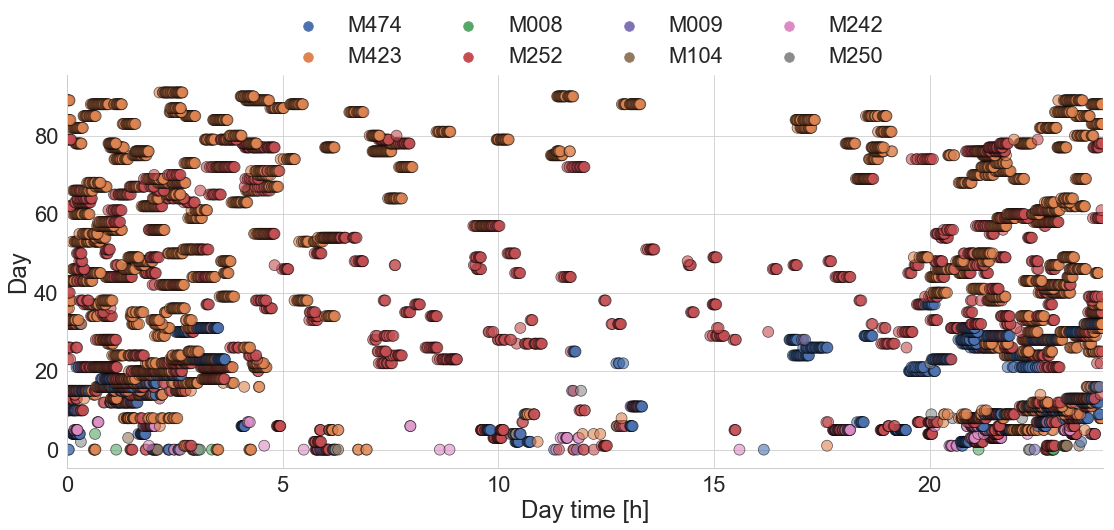

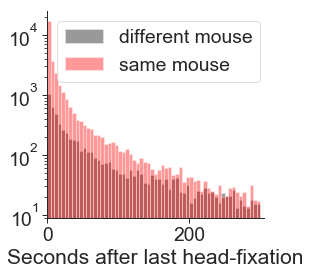

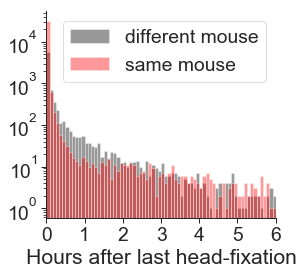

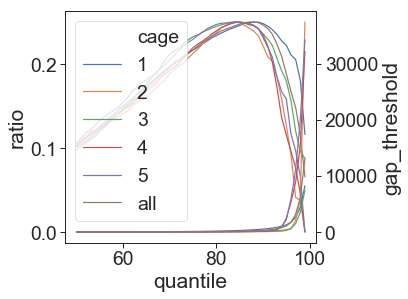

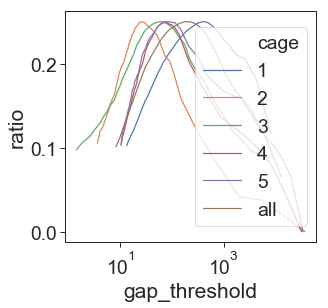

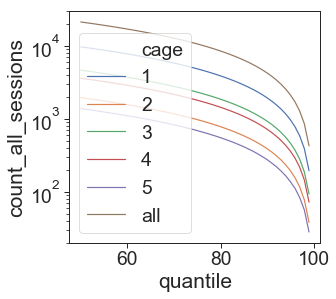

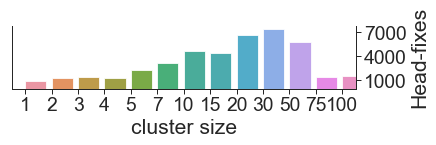

[[5.19, '1', 'same'], [146.72, '1', 'different'], [3.43, '2', 'same'], [4.715, '2', 'different'], [0.54, '3', 'same'], [36.19, '3', 'different'], [10.125, '4', 'same'], [10.83, '4', 'different'], [9.56, '5', 'same'], [1329.9650000000001, '5', 'different']]


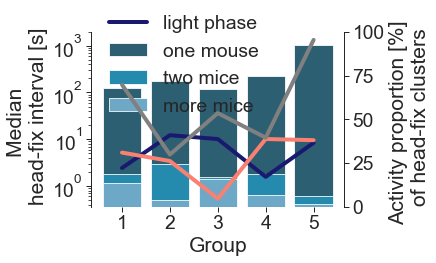

AndersonResult(statistic=14137.75829932838, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [80]:
#save_clusters()   # should just be run if the clusters need to be calculated
#kerneldensity()   # should just be run if the clusters need to be calculated

### output functions. comment which not to run. to run best use CELL -> Run all

print_entry_times_over_days()
print_entry_histogram()
quantile_verification()
analyze_clusters()
day_night_mice_count()
tests()